In [1]:
import dataclasses
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import control as ct
import control.matlab as matlab

In [2]:
@dataclasses.dataclass
class BoostParams:
    R_L: float
    L: float
    C: float
    R: float
    V_i: float
    D: float
    T: float

The operating points of the system are
$$\begin{gather} 
\frac{1-D_o^*}{R}V_o^* - I_L^* &= 0 \\
V_o^* + (1 - D^*)R_L I_L^* &= (1-D_o^*)V_i
\end{gather}$$

In [3]:
def get_operating_point(params: BoostParams):
    A = np.array([[(1 - params.D) / params.R, -1],
                 [1, (1 - params.D) * params.R_L]])
    b = np.array([0, (1 - params.D) * params.V_i])
    
    return np.linalg.inv(A) @ b

The linearized system is
$$\begin{bmatrix} \delta \dot{V_o} \\ \delta \dot{I_L} \end{bmatrix}
 = \begin{bmatrix}-\frac{1}{RC} & \frac{1}{C} - \frac{D^*}{C} \\ \frac{D^* - 1}{L} & -\frac{R_L}{L}\end{bmatrix}
 \begin{bmatrix}\delta V_o \\ \delta I_L \end{bmatrix}
 + \begin{bmatrix} -\frac{I_L^*}{C} \\ \frac{V_o^*}{L}\end{bmatrix}\delta D
$$

In [4]:
def get_ss_system(params: BoostParams):
    V_o, I_L = get_operating_point(params)
    
    A = np.array([[- 1 / (params.R * params.C), (1 - params.D) / params.C],
                  [(params.D - 1) / params.L, - params.R_L / params.L]])
    B = np.array([[-I_L / params.C],[V_o / params.L]])
    
    return ct.StateSpace(A, B, np.array([1, 0]), 0)

In [5]:
my_params = BoostParams(R_L = 1.2, L=660e-6, C=100e-6, R=1e3, V_i=4.5, D=0.5, T=1/50e3)
ct_plant = get_ss_system(my_params)
ct.tf(ct_plant)

TransferFunction(array([-1.1246626e+01,  1.7019894e+07]), array([1.00000000e+00, 1.82818182e+03, 3.80606061e+06]))

In [6]:
ct_plant.poles(), ct_plant.zeros()

(array([-914.09090909+1723.51339304j, -914.09090909-1723.51339304j]),
 array([1513333.33333333+0.j]))

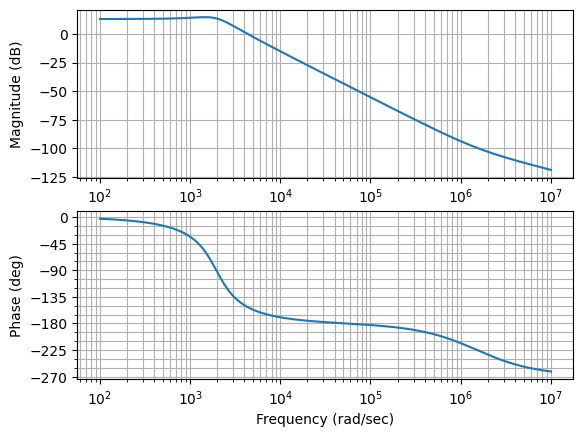

In [8]:
_ = matlab.bode(ct_plant, dB=True)

In [133]:
control_period = 10000e-6

In [134]:
dt_plant = ct_plant.sample(control_period)
ct.tf(dt_plant)

TransferFunction(array([ 4.47206303e+00, -2.33720946e-04]), array([1.00000000e+00, 9.34948964e-06, 1.14896618e-08]), 0.01)

(array([-4.67474482e-06+0.00010709j, -4.67474482e-06-0.00010709j]),
 array([5.22624445e-05+0.j]))

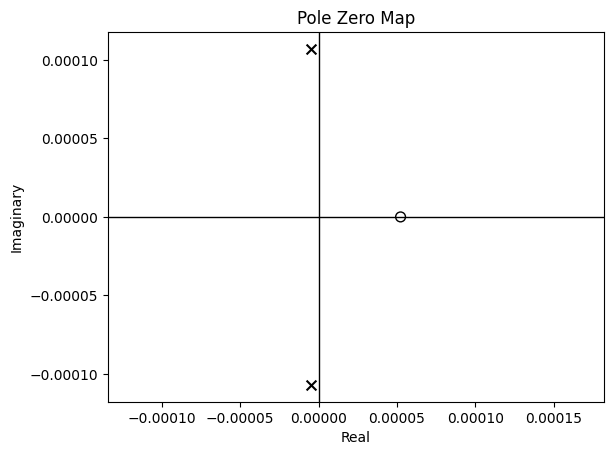

In [135]:
if any([abs(pole) > 1 for pole in dt_plant.poles()]):
    print("Poles outside unit circle")
if any([abs(zero) > 1 for zero in dt_plant.zeros()]):
    print("Zeros outside unit circle")
    
ct.matlab.pzmap(dt_plant)

In [150]:
k_p = 0.05
k_i = 1
k_d = 0.0

controller = ct.TransferFunction([k_p + k_i * control_period, -k_p], [1, -1], dt=control_period)
controller

TransferFunction(array([ 0.06, -0.05]), array([ 1, -1]), 0.01)

In [151]:
feedback_system = ct.series(controller, dt_plant).feedback()

(array([ 9.63703404e-01+0.j, -2.32088731e-01+0.j,  5.21966926e-05+0.j]),
 array([8.33333333e-01+0.j, 5.22624445e-05+0.j]))

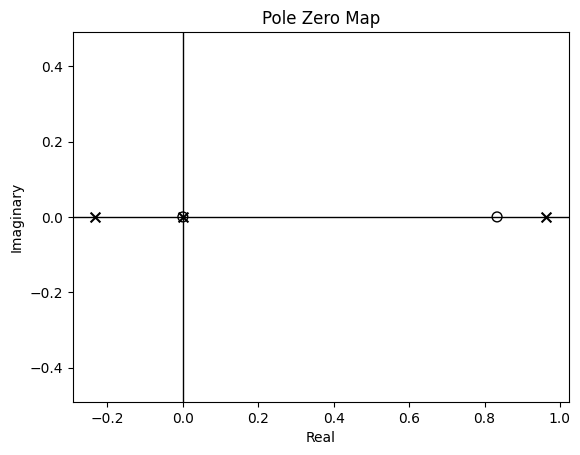

In [152]:
if any([abs(pole) > 1 for pole in feedback_system.poles()]):
    print("Poles outside unit circle")
ct.matlab.pzmap(feedback_system)

In [165]:
1 / 25e3

4e-05